In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    print('memory growth:' , tf.config.experimental.get_memory_growth(gpu))

gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
memory growth: True


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

In [3]:
train_data = pd.read_csv('/home/dawidkubicki/Datasets/fashion-MNIST/train.csv')

In [4]:
y_train = train_data["label"]
X_train = train_data.drop(columns=["label"])

In [5]:
X_train = X_train.to_numpy().reshape(-1, 28, 28)

In [6]:
y_train = y_train.to_numpy()

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
y_train = y_train.reshape(-1,1)

In [9]:
y_train.shape

(60000, 1)

In [10]:
X_train = X_train / 255

In [11]:
X_train = X_train[..., tf.newaxis].astype("float32")

In [12]:
#turn those numpy arrays to tensorflow tensors
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)

In [13]:
train_ds

<BatchDataset shapes: ((None, 28, 28, 1), (None, 1)), types: (tf.float32, tf.int64)>

In [14]:
# tfds.list_tbuilders()


In [15]:
# train_data = tfds.load('fashion_mnist', split='train', as_supervised=True, shuffle_files=True).batch(32)
# test_data = tfds.load('fashion_mnist', split='test',as_supervised=True, shuffle_files=False).batch(32)
# assert isinstance(train_data, tf.data.Dataset)
# assert isinstance(test_data, tf.data.Dataset)

In [16]:
# train_data

In [17]:
# ts = train_data.take(1)

# for batch, (image, label) in enumerate(ts):
#     image.cast(image, dtype=tf.float32)
#     plt.imshow(image[batch])
#     print(batch)

In [18]:
class ConvolutionalModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, 3, activation='relu')
        self.maxp1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.maxp2 = tf.keras.layers.MaxPooling2D()
        self.flt = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(450, activation='relu')
        self.fc3 = tf.keras.layers.Dense(10)
        
    def call(self, X):
        X = self.conv1(X)
        X = self.maxp1(X)
        X = self.conv2(X)
        X = self.maxp2(X)
        X = self.flt(X)
        X = self.fc1(X)
        X = self.fc2(X)
        return self.fc3(X)
        
model = ConvolutionalModel()

In [19]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [20]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

losses = []
accuracies = []

In [21]:
def train_step(images, labels):
    
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = criterion(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, predictions)
    
    losses.append(loss)
    accuracies.append(train_accuracy)

In [22]:
EPOCHS = 6

for epoch in range(EPOCHS):
    
    for batch, (images, labels) in enumerate(train_ds):
        train_step(images, labels)
        
        if batch%200 == 0:
        
            print(
            f'Epoch {epoch+1},'
            f'Loss {train_loss.result()}, '
            f'Accuracy {train_accuracy.result() * 100}, '
    #         f'Test Loss: {test_loss.result()},'
    #         f'Test Accuracy: {test_accuracy.result() *100}'
        )

Epoch 1,Loss 2.3351798057556152, Accuracy 6.25, 
Epoch 1,Loss 0.8458186388015747, Accuracy 68.26803588867188, 
Epoch 1,Loss 0.7009326815605164, Accuracy 73.33229064941406, 
Epoch 1,Loss 0.6304949522018433, Accuracy 76.06593322753906, 
Epoch 1,Loss 0.5842843055725098, Accuracy 77.87531280517578, 
Epoch 1,Loss 0.5582619309425354, Accuracy 78.91171264648438, 
Epoch 1,Loss 0.5314498543739319, Accuracy 80.0556869506836, 
Epoch 1,Loss 0.5097853541374207, Accuracy 80.91987609863281, 
Epoch 1,Loss 0.49240946769714355, Accuracy 81.61305236816406, 
Epoch 1,Loss 0.4789760708808899, Accuracy 82.1227798461914, 
Epoch 2,Loss 0.47424909472465515, Accuracy 82.2861099243164, 
Epoch 2,Loss 0.4606587290763855, Accuracy 82.78089141845703, 
Epoch 2,Loss 0.4502324163913727, Accuracy 83.15850067138672, 
Epoch 2,Loss 0.4397168755531311, Accuracy 83.54074096679688, 
Epoch 2,Loss 0.4297039210796356, Accuracy 83.9067153930664, 
Epoch 2,Loss 0.422471821308136, Accuracy 84.19245147705078, 
Epoch 2,Loss 0.415076673

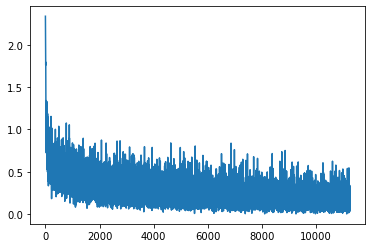

In [24]:
plt.plot(losses)